# Preprocessing pipeline


This pipeline aims to serve as a semiautomatic and reproducible framework for preprocessing EEG signals before performing time-frequency-based analysis. It minimizes the manual steps required to clean the data based on visual inspection. It is advised to revisit the cleaned epochs before writing the final preprocessed file. 


## Outline

1. __Temporal filtering__

High-frequency artefacts and slow drifts are removed with a zero-phase bandpass filter using mne-Python [1]. The cutoff frequencies (0.5 - 45 Hz) can be modified in the utils folder in the configuration file (config.py). 


2. __Create epochs__ 

Epochs are nonoverlapping data segments created from the continuous data with a duration of 1 seconds. The length of epochs can be changed in the configuration file.
Epochs can be created from (1) events; there is a custom method that created epochs based on annotations in the raw data, (2) without events, data segments are created from the beginning of the raw data. 


3. __Outlier data rejection__  

    3.1. _Preliminar rejection_  
Epochs are rejected based on a global threshold on the z-score (> 3) of the epoch variance and amplitude range.

    3.2. _ICA decomposition_  
The default method is the infomax algorithm, however it can be changed in the configuration file along with the number of components and the decimation parameter. Components containing blink artefacts are automatically marked with mne-Python.
The ICA sourced can be visualized and interactively selected and rejected based on their topographies, time-courses or frequency spectra. The number of components that were removed from the data are documented in the “description” field of the epochs instance “info” structure.

    3.3. _Autoreject_  
Autoreject [2, 3] uses unsupervised learning to estimate the rejection threshold for the epochs. In order to reduce computation time that increases with the number of segments and channels, autoreject can be fitted on a representative subset of epochs (25% of total epochs). Once the parameters are learned, the solution can be applied to any data that contains channels that were used during fit.


4. __Outlier channel interpolation__

The Random Sample Consensus (RANSAC) algorithm [4] selects a random subsample of good channels to make predictions of each channel in small non-overlapping 4 seconds long time windows. It uses a method of spherical splines (Perrin et al., 1989) to interpolate the bad sensors. The sensors that were interpolated are added to the "description" field of the epochs "info" structure. 


<img src="static/preprocessing_pipeline_diagram.svg">


## References

[1] A. Gramfort, M. Luessi, E. Larson, D. Engemann, D. Strohmeier, C. Brodbeck, R. Goj, M. Jas, T. Brooks, L. Parkkonen, M. Hämäläinen, MEG and EEG data analysis with MNE-Python, Frontiers in Neuroscience, Volume 7, 2013, ISSN 1662-453X

[2] Mainak Jas, Denis Engemann, Federico Raimondo, Yousra Bekhti, and Alexandre Gramfort, “Automated rejection and repair of bad trials in MEG/EEG.” In 6th International Workshop on Pattern Recognition in Neuroimaging (PRNI), 2016.

[3] Mainak Jas, Denis Engemann, Yousra Bekhti, Federico Raimondo, and Alexandre Gramfort. 2017. “Autoreject: Automated artifact rejection for MEG and EEG data”. NeuroImage, 159, 417-429.

[4] Bigdely-Shamlo, N., Mullen, T., Kothe, C., Su, K. M., & Robbins, K. A. (2015). The PREP pipeline: standardized preprocessing for large-scale EEG analysis. Frontiers in neuroinformatics, 9, 16.



## Import packages


```%matplotlib qt``` is the recommended backend for interactive visualization (can be slower);    

switch to ```%matplotlib inline``` for (faster) static plots

In [1]:
import os
from ipyfilechooser import FileChooser

from meeg_tools.preprocessing import *
from meeg_tools.utils.epochs import create_epochs_from_events, create_metadata
from meeg_tools.utils.raw import read_raw_measurement, filter_raw
from meeg_tools.utils.log import update_log

from meeg_tools.utils.config import settings

from matplotlib import pyplot as plt
%matplotlib qt

## Load raw data


See [this](https://mne.tools/stable/auto_tutorials/io/20_reading_eeg_data.html) documentation for help with supported file formats.  

In [2]:
# Use the widget to navigate to the experiment folder path and select an EEG file 
base_path = '/Volumes/crnl-memo-hd/TMS_rewiring/'
fc = FileChooser(base_path)
fc.filter_pattern = ['*.vhdr', '*.edf']

display(fc)

FileChooser(path='/Volumes/crnl-memo-hd/TMS_rewiring', filename='', title='HTML(value='', layout=Layout(displa…

In [3]:
# Load selected file
raw = read_raw_measurement(raw_file_path=fc.selected)
raw.info

Extracting parameters from /Volumes/crnl-memo-hd/TMS_rewiring/Raw_data/54_E/Day1/EEG/54_E_Day1.vhdr...
Setting channel info structure...


<Info | 9 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 64 items (64 EEG)
 fid: 54_E_Day1
 highpass: 0.0 Hz
 lowpass: 1000.0 Hz
 meas_date: 2021-01-28 09:29:48 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>

## Temporal filtering

- bandpass filter (0.5 - 45 Hz)

In [ ]:
settings['bandpass_filter']

In [4]:
raw_bandpass = filter_raw(raw)

Reading 0 ... 2988839  =      0.000 ...  5977.678 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 3301 samples (6.602 sec)



[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  10 tasks      | elapsed:    8.2s
[Parallel(n_jobs=8)]: Done  64 out of  64 | elapsed:   27.8s finished


## Create epochs

- select the events for analysis

In [5]:
settings['epochs']['start_time'] = -0.25
settings['epochs']['end_time'] = 0.75

In [6]:
events_ids = np.concatenate([np.arange(10, 53, 1), 
                             np.arange(10, 53, 1) + 100,
                            [211, 212, 213, 214, 215, 216]])

epochs = create_epochs_from_events(raw=raw_bandpass, event_ids=[events_ids])

Used Annotations descriptions: ['New Segment/', 'Stimulus/S  5', 'Stimulus/S 10', 'Stimulus/S 11', 'Stimulus/S 12', 'Stimulus/S 14', 'Stimulus/S 15', 'Stimulus/S 16', 'Stimulus/S 17', 'Stimulus/S 18', 'Stimulus/S 19', 'Stimulus/S 20', 'Stimulus/S 21', 'Stimulus/S 22', 'Stimulus/S 24', 'Stimulus/S 25', 'Stimulus/S 26', 'Stimulus/S 27', 'Stimulus/S 28', 'Stimulus/S 29', 'Stimulus/S 30', 'Stimulus/S 31', 'Stimulus/S 32', 'Stimulus/S 34', 'Stimulus/S 35', 'Stimulus/S 36', 'Stimulus/S 37', 'Stimulus/S 38', 'Stimulus/S 39', 'Stimulus/S 40', 'Stimulus/S 41', 'Stimulus/S 42', 'Stimulus/S 43', 'Stimulus/S 44', 'Stimulus/S 45', 'Stimulus/S 46', 'Stimulus/S 47', 'Stimulus/S 48', 'Stimulus/S 49', 'Stimulus/S 51', 'Stimulus/S 52', 'Stimulus/S 61', 'Stimulus/S 62', 'Stimulus/S 63', 'Stimulus/S 64', 'Stimulus/S 65', 'Stimulus/S 66', 'Stimulus/S 67', 'Stimulus/S 68', 'Stimulus/S 69', 'Stimulus/S 70', 'Stimulus/S 71', 'Stimulus/S 72', 'Stimulus/S 75', 'Stimulus/S 76', 'Stimulus/S 77', 'Stimulus/S 78', 

## Create metadata for epochs (optional)

- adding metadata makes it easier to select epochs of different types
- custom triggers are selected from the raw instance

- metadata can be added or replaced later (e.g. after preprocessing)

In [7]:
metadata = create_metadata(epochs)
metadata.head(10)

epochs.metadata = metadata

Found these indices for these epoch boundary events: 
211	1342
212	2676
213	4024
214	5370
215	6720
Adding metadata with 8 columns


In [ ]:
# we can filter epochs as a query
epochs["triplet == 'H' & answer == 'incorrect'"]

In [ ]:
epochs["epoch == 5 & triplet == 'L'"]

In [8]:
# subselecting epochs 
# Here we could also include thrills, repetitions, or practice stimuli.
# ICA should not run on duplicate data (epochs should not be overlapping!)

epochs = epochs["triplet == 'L' | triplet == 'H'"]

## Run preprocessing


### 1.1. Preliminary epoch rejection

In [9]:
epochs_faster = prepare_epochs_for_ica(epochs=epochs)

Preliminary epoch rejection: 
Loading data for 1728 events and 501 original time points ...
0 bad epochs dropped
Bad epochs by amplitude
	[  46   48  107  297  570  596  629  630  658  764  845  921  934  974
 1065 1206 1207 1223 1261 1262 1282 1331 1344 1359 1361 1373 1374 1377
 1378 1399 1546 1679 1717 1718 1719]
Bad epochs by deviation
	[  46   87   99  107  108  199  201  297  298  346  404  417  495  496
  501  554  570  571  595  596  597  629  632  638  647  648  658  686
  696  740  826  921  934  974 1065 1156 1187 1205 1206 1207 1208 1261
 1331 1332 1344 1345 1359 1360 1361 1373 1374 1375 1377 1378 1379 1390
 1394 1439 1612 1717]
Bad epochs by variance
	[  46   48  107  297  570  595  596  630  658  764  921  934  946  974
 1065 1195 1206 1207 1208 1223 1262 1282 1331 1344 1354 1359 1361 1373
 1374 1377 1378 1399 1679 1718]
Dropped 75 epochs: 46, 48, 87, 99, 107, 108, 199, 201, 297, 298, 346, 404, 417, 495, 496, 501, 554, 570, 571, 595, 596, 597, 629, 630, 632, 638, 647, 648,

### 1.2. Run ICA


The parameters are: 32 ICA components using ["infomax"](https://mne.tools/stable/generated/mne.preprocessing.infomax.html) algorithm. 

When visualizing the components, it is recommended to subset the data (see below).

In [10]:
ica = run_ica(epochs=epochs_faster)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Loading data for 1653 events and 501 original time points ...
Selecting by number: 32 components
 


/Users/weian/venv/eeg-preprocessing/lib/python3.7/site-packages/mne/preprocessing/infomax_.py:192: RuntimeWarning: overflow encountered in exp
  y = 1.0 / (1.0 + np.exp(-u))


Loading data for 1653 events and 501 original time points ...
Fitting ICA took 203.8s.
EOG channels are not found. Attempting to use Fp1,Fp2 channels as EOG channels.
Loading data for 1653 events and 501 original time points ...
Loading data for 1653 events and 501 original time points ...
Loading data for 1653 events and 501 original time points ...
Loading data for 1653 events and 501 original time points ...


In [11]:
# Plot component topographies
ica.plot_components()

[<Figure size 1950x1884 with 20 Axes>, <Figure size 1950x1413 with 12 Axes>]

Loading data for 1653 events and 501 original time points ...
Not setting metadata
Not setting metadata
1653 matching events found
No baseline correction applied
0 projection items activated
0 bad epochs dropped


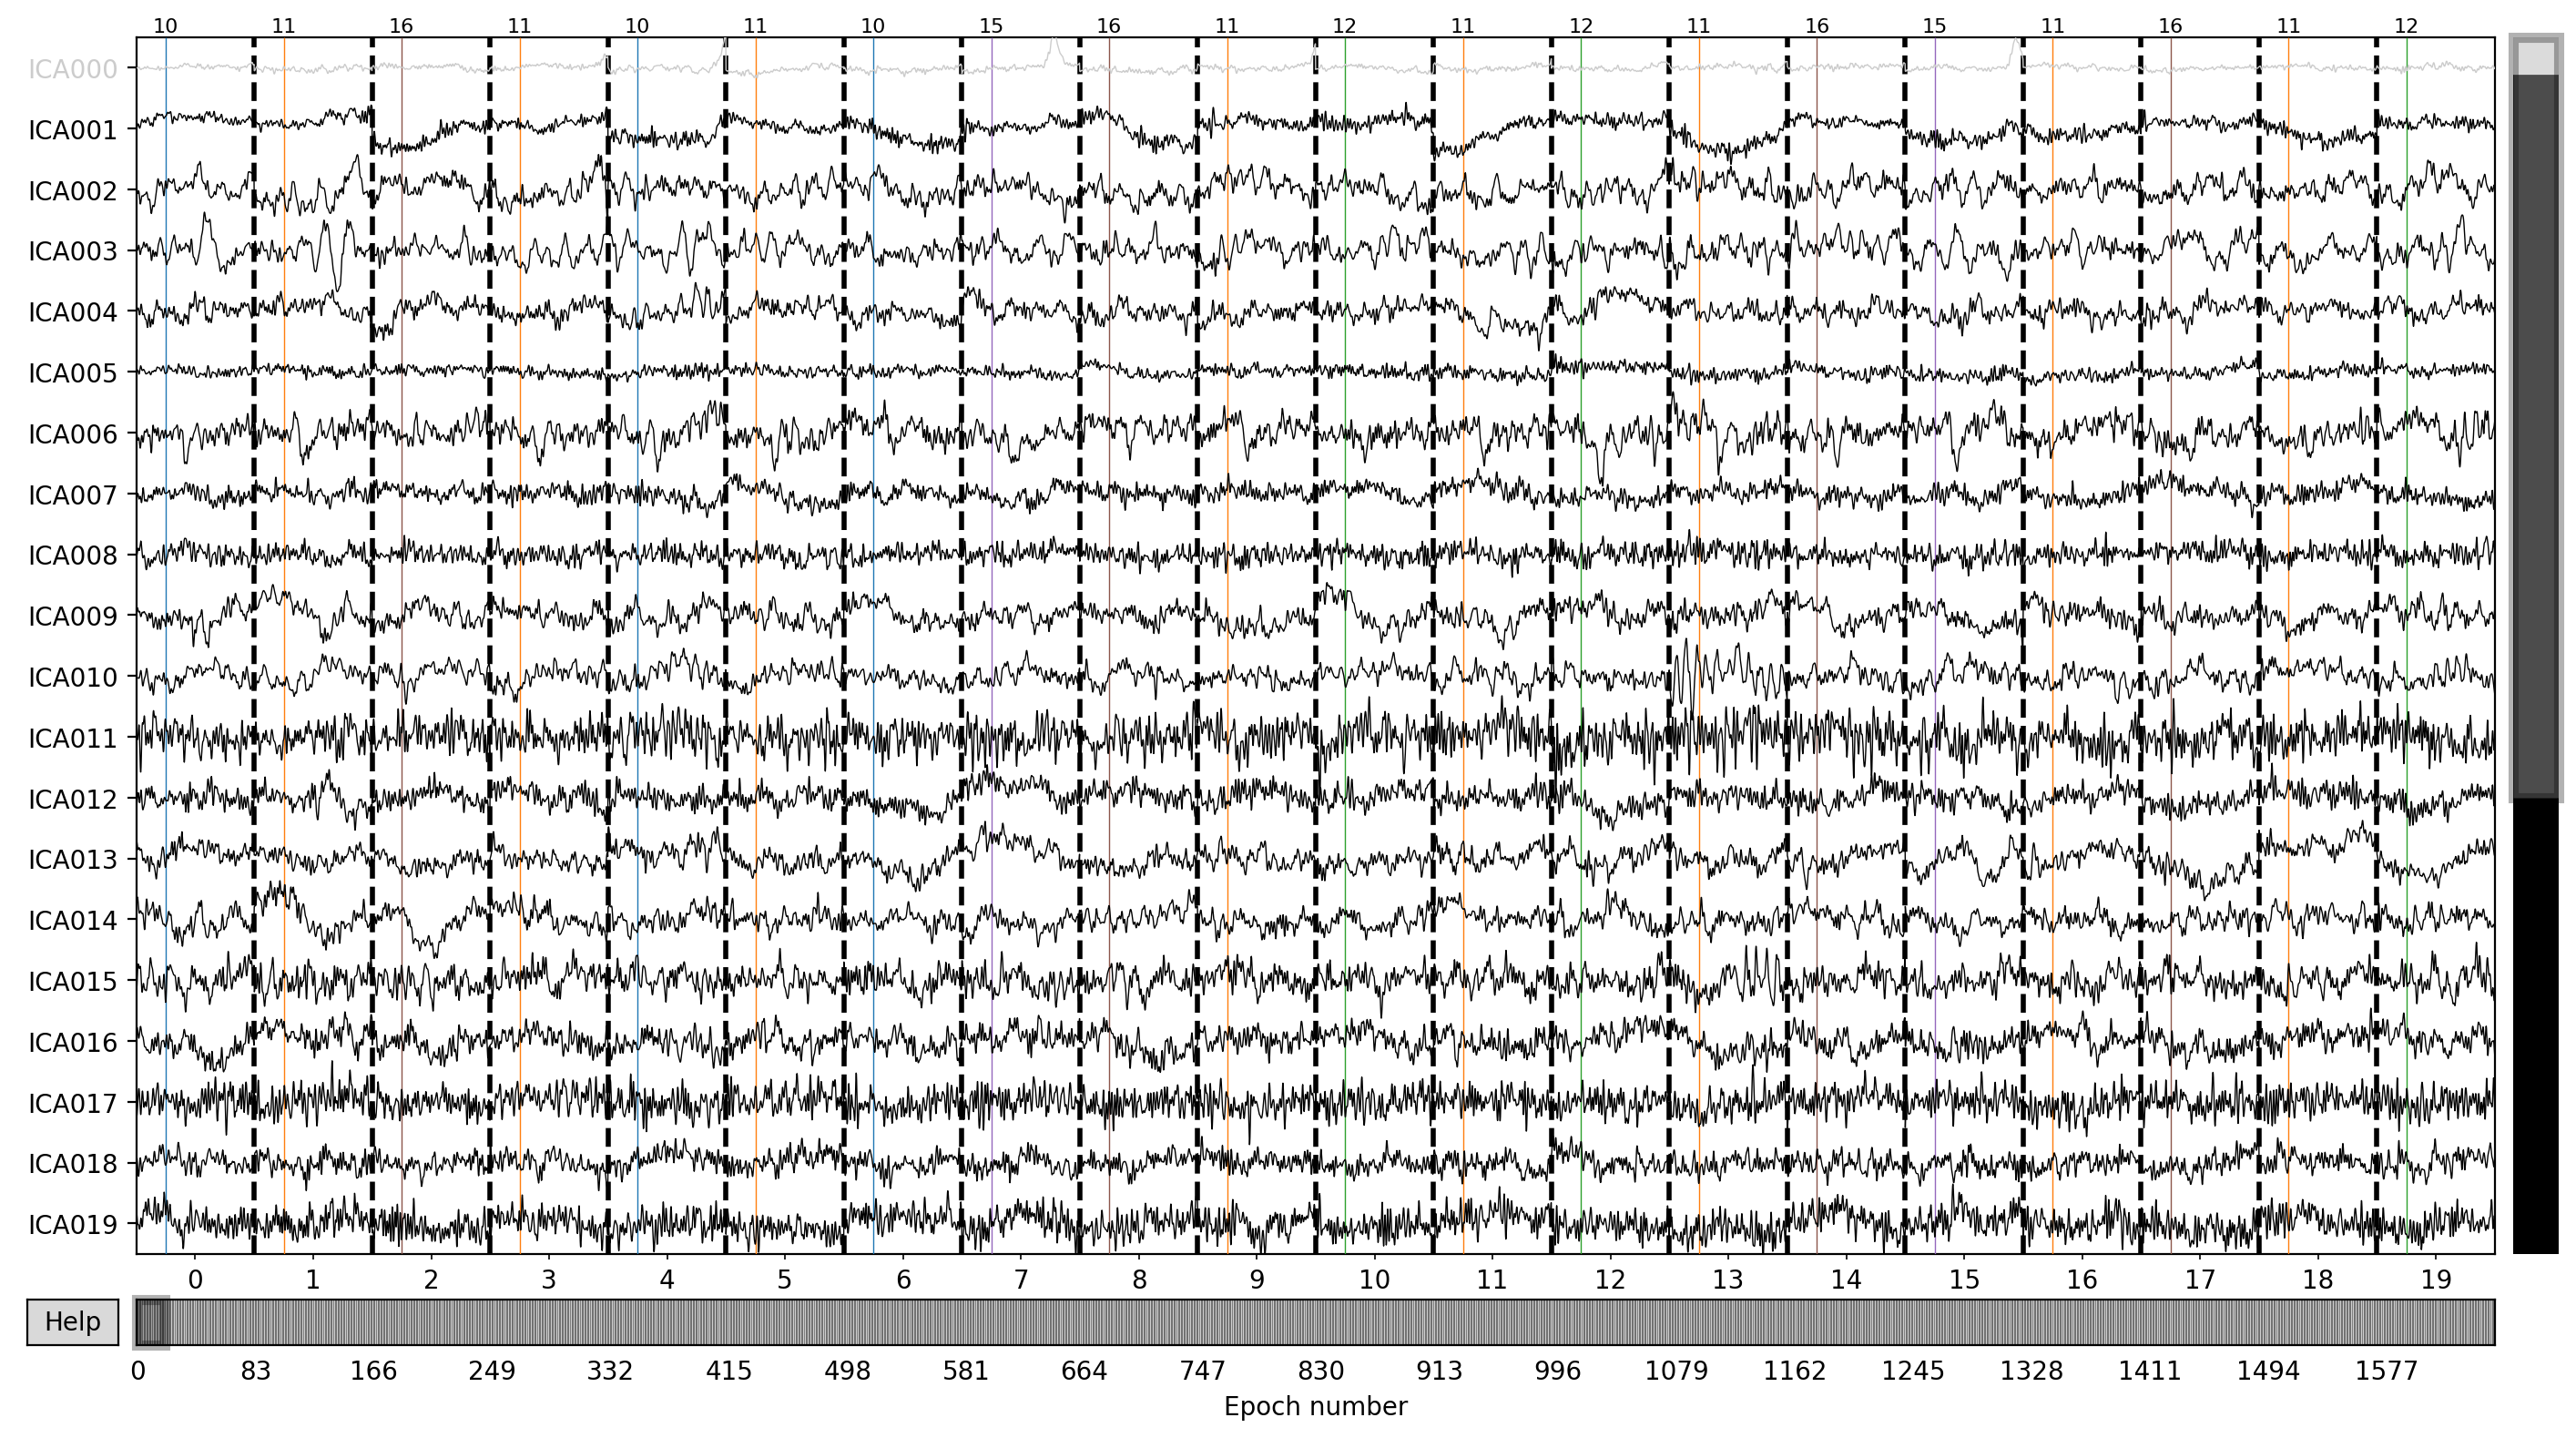

In [12]:
# Visualize components on epochs
# Subset epochs to reduce execution time (e.g. take epochs from every 5th event)
#subset = list(epochs.event_id.keys())[::7]
# Exclude components by selecting them, right click on component name to visulize source:
ica.plot_sources(epochs_faster)

In [13]:
# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster.load_data())
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

Loading data for 1653 events and 501 original time points ...
Applying ICA to Epochs instance
    Transforming to ICA space (32 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components


### 1.3. Visualize ICA cleaned epochs (optional)

This step can be repeated after each preprocessing step, or you can also do a final inspection at the end. 

In [ ]:
# Optional
epochs_faster[subset].plot(n_epochs=10, n_channels=32, scalings={'eeg': 20e-6},)

In [ ]:
# Optional
# If you found a component that should have been excluded but it wasn't you can exclude it here:
ica.plot_sources(epochs_faster)

# After selecting the components to exclude, apply ICA to epochs
# Document the number of excluded components
ica.apply(epochs_faster)
epochs_faster.info['description'] = f'n_components: {len(ica.exclude)}'

### 1.4. Save cleaned epochs (recommended)

In [14]:
# Create folder for preprocessed and interim files
folder_name = 'preprocessed'
epochs_path = os.path.join(base_path, folder_name, 'epochs_asrt')


# Create path to epoch files
if not os.path.exists(epochs_path):
    os.makedirs(epochs_path)

# Save ICA cleaned epochs 
fid = epochs.info['fid']
epochs_faster.info.update(fid=f'{fid}_ICA')
postfix = '-epo.fif.gz'
epochs_faster.save(os.path.join(epochs_path, f'{epochs_faster.info["fid"]}{postfix}'), overwrite=True)

In [15]:
epochs_faster.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 2
 dig: 64 items (64 EEG)
 fid: 54_E_Day1_ICA
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2021-01-28 09:29:48 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>

### 1.5. Create a log file 

We can create a log file for the preprocessed data and store metadata
that could be useful to remember. You can add more columns to this, or 
remove the ones that are not needed. For documentation purporses, it is 
recommended to store the number of rejected and total epochs, the number of
ICA components that were rejected, the number of interpolated electrodes etc.
You can also add a column with "notes" to add custom descriptions about the data.

In [16]:
notes = ''

In [17]:
log_file_path = os.path.join(os.path.join(base_path, 'preprocessed', 'epochs_asrt'), 'log.csv')
update_log(log_file_path, epochs_faster, notes)

fid  highpass  lowpass  n_components  n_bad_epochs  \
0  54_E_Day1_ICA       0.5     45.0           2.0            75   

   n_total_epochs  drop_percentage                   stimuli  t_min  t_max  \
0            1653             4.34  [10, 11, 12, 14, 15, 16]  -0.25   0.75   

   n_interpolated  average_ref_applied  baseline notes  \
0             NaN                False       NaN         

               date_of_update  
0  2021-08-31T15:40:41.286282

### 2.1. Run autoreject

In [18]:
reject_log = run_autoreject(epochs_faster.load_data(), n_jobs=11, subset=True)

Fitting autoreject on random (n=413) subset of epochs: 
Running autoreject on ch_type=eeg


Computing thresholds ...: 100%|██████████| 64/64 [00:48<00:00,  1.31it/s]


Repairing epochs:   0%|          | 0/413 [00:00<?, ?it/s]

Repairing epochs:   3%|▎         | 12/413 [00:00<00:03, 115.05it/s]

Repairing epochs:   6%|▌         | 24/413 [00:00<00:03, 117.32it/s]

Repairing epochs:  10%|█         | 43/413 [00:00<00:02, 148.20it/s]

Repairing epochs:  15%|█▌        | 62/413 [00:00<00:02, 162.59it/s]

Repairing epochs:  19%|█▉        | 79/413 [00:00<00:02, 158.17it/s]

Repairing epochs:  23%|██▎       | 96/413 [00:00<00:01, 159.68it/s]

Repairing epochs:  29%|██▉       | 120/413 [00:00<00:01, 182.95it/s]

Repairing epochs:  34%|███▎      | 139/413 [00:00<00:01, 178.24it/s]

Repairing epochs:  39%|███▊      | 160/413 [00:00<00:01, 186.98it/s]

Repairing epochs:  45%|████▍     | 185/413 [00:01<00:01, 204.40it/s]

Repairing epochs:  50%|█████     | 208/413 [00:01<00:00, 211.86it/s]

Repairing epochs:  56%|█████▋    | 233/413 [00:01<00:00, 221.19it/s]

Repairing epochs:  62%|██████▏ 

Repairing epochs:  19%|█▉        | 78/413 [00:01<00:04, 70.40it/s]

Repairing epochs:  21%|██        | 86/413 [00:01<00:05, 59.51it/s]

Repairing epochs:  23%|██▎       | 93/413 [00:01<00:06, 51.74it/s]

Repairing epochs:  24%|██▍       | 99/413 [00:01<00:06, 46.61it/s]

Repairing epochs:  25%|██▌       | 104/413 [00:01<00:06, 44.55it/s]

Repairing epochs:  27%|██▋       | 110/413 [00:01<00:06, 47.32it/s]

Repairing epochs:  28%|██▊       | 116/413 [00:01<00:06, 49.04it/s]

Repairing epochs:  30%|██▉       | 122/413 [00:02<00:05, 51.72it/s]

Repairing epochs:  32%|███▏      | 131/413 [00:02<00:04, 58.67it/s]

Repairing epochs:  33%|███▎      | 137/413 [00:02<00:04, 56.03it/s]

Repairing epochs:  35%|███▍      | 143/413 [00:02<00:05, 49.81it/s]

Repairing epochs:  36%|███▌      | 149/413 [00:02<00:05, 45.53it/s]

Repairing epochs:  38%|███▊      | 156/413 [00:02<00:05, 51.00it/s]

Repairing epochs:  40%|███▉      | 164/413 [00:02<00:04, 58.02it/s]

Repairing epochs:  41%|████▏     | 171

Repairing epochs:  83%|████████▎ | 343/413 [00:05<00:01, 61.17it/s]

Repairing epochs:  85%|████████▍ | 350/413 [00:05<00:01, 59.23it/s]

Repairing epochs:  86%|████████▌ | 356/413 [00:05<00:01, 56.86it/s]

Repairing epochs:  88%|████████▊ | 362/413 [00:05<00:00, 55.56it/s]

Repairing epochs:  89%|████████▉ | 369/413 [00:06<00:00, 59.08it/s]

Repairing epochs:  91%|█████████ | 376/413 [00:06<00:00, 60.11it/s]

Repairing epochs:  93%|█████████▎| 383/413 [00:06<00:00, 58.32it/s]

Repairing epochs:  94%|█████████▍| 389/413 [00:06<00:00, 58.40it/s]

Repairing epochs:  96%|█████████▌| 396/413 [00:06<00:00, 60.24it/s]

Repairing epochs:  98%|█████████▊| 403/413 [00:06<00:00, 61.62it/s]

Repairing epochs: 100%|██████████| 413/413 [00:06<00:00, 60.08it/s]



Fold:   0%|          | 0/10 [00:00<?, ?it/s]


Fold:  10%|█         | 1/10 [00:00<00:06,  1.48it/s]


Fold:  20%|██        | 2/10 [00:01<00:05,  1.48it/s]


Fold:  30%|███       | 3/10 [00:02<00:04,  1.46it/s]


Fold:  40%|████      | 4/10





Estimated consensus=0.60 and n_interpolate=32

AUTOREJECT report
There are 75 bad epochs found with Autoreject. You can assess these epochs with reject_log.bad_epochs

There are 408 bad epochs where more than 15% of the channels were noisy. You can assess these epochs with reject_log.report


In [19]:
# Here you can decide how strict should be the epoch rejection.
# You can drop only those that were marked as bad epochs, or a more 
# strict rejection threshold can be if you drop epochs where more than
# 15% of the channels were marked as noisy.

# You can plot the epochs with Autoreject, where bad epochs are marked with
# red colors. 

# reject_log.plot_epochs(epochs_faster)


# rejecting only bad epochs
# epochs_autoreject = epochs_faster.copy().drop(reject_log.bad_epochs, reason='AUTOREJECT')

# rejecting those epochs too where more than 15% of the channels are marked as noisy
#bads = np.where(np.count_nonzero(reject_log.labels, axis=1) > 0.15 * epochs_faster.info['nchan'])[0].tolist()

# you can plot just the bad epochs to double check how strict this rejection is
# if bads: 
#     epochs_faster[bads].plot(n_epochs=10,
#                                 scalings={'eeg': 20e-6},
#                                 n_channels=32)


epochs_autoreject = epochs_faster.copy().drop(reject_log.report, reason='AUTOREJECT')

Dropped 408 epochs: 35, 41, 46, 66, 85, 88, 92, 99, 101, 119, 120, 121, 162, 169, 170, 171, 180, 194, 195, 196, 219, 221, 227, 228, 245, 253, 255, 258, 259, 261, 262, 265, 272, 296, 298, 302, 316, 322, 324, 334, 337, 341, 342, 347, 349, 353, 354, 364, 368, 375, 381, 382, 385, 386, 389, 390, 391, 392, 402, 406, 429, 432, 433, 434, 435, 438, 439, 467, 470, 473, 474, 478, 481, 487, 488, 489, 493, 509, 513, 529, 530, 531, 532, 533, 538, 543, 552, 553, 554, 566, 572, 573, 575, 579, 581, 586, 587, 589, 592, 599, 607, 612, 617, 618, 620, 636, 637, 638, 639, 654, 655, 664, 677, 678, 679, 699, 702, 703, 704, 705, 708, 726, 727, 730, 731, 736, 744, 746, 747, 756, 759, 762, 763, 764, 777, 779, 780, 784, 795, 803, 804, 807, 808, 810, 811, 821, 823, 824, 825, 826, 827, 840, 842, 843, 844, 846, 847, 848, 852, 854, 855, 856, 857, 875, 876, 879, 880, 881, 882, 883, 890, 891, 892, 899, 902, 913, 925, 927, 929, 944, 948, 951, 952, 958, 959, 981, 982, 983, 985, 986, 987, 990, 991, 995, 996, 997, 999, 100

In [ ]:
epochs_faster[reject_log.report].plot(n_epochs=10,
                                scalings={'eeg': 20e-6},
                                      n_channels=32)



In [ ]:
epochs_autoreject.plot(n_epochs=10, n_channels=32, scalings={'eeg': 20e-6},)

In [20]:
# save clean epochs
fid = epochs.info['fid']
epochs_autoreject.info.update(fid=f'{fid}_ICA_autoreject')
postfix = '-epo.fif.gz'
epochs_autoreject.save(os.path.join(epochs_path, f'{epochs_autoreject.info["fid"]}{postfix}'), overwrite=True)

In [21]:
update_log(log_file_path, epochs_autoreject, '')

fid  highpass  lowpass  n_components  n_bad_epochs  \
0  54_E_Day1_ICA_autoreject       0.5     45.0           2.0           483   

   n_total_epochs  drop_percentage                   stimuli  t_min  t_max  \
0            1245            27.95  [10, 11, 12, 14, 15, 16]  -0.25   0.75   

   n_interpolated  average_ref_applied  baseline notes  \
0             NaN                False       NaN         

               date_of_update  
0  2021-08-31T15:44:30.308730

### 3. Run ransac

In [22]:
ransac = run_ransac(epochs_autoreject)

Iterating epochs ...


[Parallel(n_jobs=11)]: Using backend LokyBackend with 11 concurrent workers.
[Parallel(n_jobs=11)]: Done   2 out of  11 | elapsed:   14.5s remaining:  1.1min
[Parallel(n_jobs=11)]: Done   4 out of  11 | elapsed:   15.1s remaining:   26.4s
[Parallel(n_jobs=11)]: Done   6 out of  11 | elapsed:   16.4s remaining:   13.7s
[Parallel(n_jobs=11)]: Done   8 out of  11 | elapsed:   17.5s remaining:    6.6s


[Done]

RANSAC report
There are 3 channels that were noisy for > 20% of the time:
TP10	0.62
TP9	0.47
T7	0.24

RANSAC marked TP9, TP10 channels to be interpolated.You can assess these channels with ransac.bad_chs_


[Parallel(n_jobs=11)]: Done  11 out of  11 | elapsed:   20.8s finished


In [29]:
ransac.bad_chs_ = ['TP9', 'TP10', 'T7', 'TP7']

In [30]:
epochs_ransac = epochs_autoreject.copy()
epochs_ransac.info['bads'] = ransac.bad_chs_

# epochs_ransac.interpolate_bads()
bads_str = ', '.join(ransac.bad_chs_)
epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
# Alternatively, you can interpolate the channels that were reported before 
# epochs_ransac.info['bads'] = ransac.report

epochs_ransac.interpolate_bads(reset_bads=True)

Interpolating bad channels
    Automatic origin fit: head of radius 85.0 mm
Computing interpolation matrix from 60 sensor positions
Interpolating 4 sensors


<Epochs |  1245 events (all good), -0.25 - 0.75 sec, baseline off, ~304.7 MB, data loaded, with metadata,
 '10': 135
 '11': 545
 '12': 140
 '14': 48
 '15': 157
 '16': 220>

In [25]:
# inspect which sensors were interpolated (if any)
epochs_ransac.info

<Info | 10 non-empty values
 bads: []
 ch_names: Fp1, Fz, F3, F7, FT9, FC5, FC1, C3, T7, TP9, CP5, CP1, Pz, P3, ...
 chs: 64 EEG
 custom_ref_applied: False
 description: n_components: 2, interpolated: TP9, TP10
 dig: 64 items (64 EEG)
 fid: 54_E_Day1_ICA_autoreject
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2021-01-28 09:29:48 UTC
 nchan: 64
 projs: []
 sfreq: 500.0 Hz
>

## 4. Final visual inspection

Mark epochs that should be dropped,  etc.

In [ ]:
epochs_autoreject[::7].plot(n_epochs=10,
                       n_channels=32,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
# If there were no bad channels found, however there are clearly some bad ones
# you can you the epochs_ransac object to mark bad channels

# example
# epochs_ransac.info['bads'] = ['Fp1', 'F7']
# epochs_ransac.interpolate_bads()
# bads_str = ', '.join(['Fp1', 'F7'])
# epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
# log['n_interpolated'].update(len(['Fp1', 'F7']))


# However, if you found additional channels (addition to those that were found with RANSAC)
# then you should use the epochs_autoreject object (don't interpolate the same object twice)

# example
# epochs_ransac = epochs_autoreject.copy()
# epochs_ransac.info['bads'] = ['Fp1', 'F7']
# bads_str = ', '.join(['Fp1', 'F7'])
# epochs_ransac.info.update(description=epochs_ransac.info['description'] + ', interpolated: ' + bads_str)
# log['n_interpolated'].update(len(['Fp1', 'F7']))


## 5. Apply baseline and set average reference

### 5.1. Apply baseline (optional)



In [ ]:
epochs_ransac.apply_baseline(baseline=(-0.25, 0.0))

### 5.2. Set average reference

To set a “virtual reference” that is the average of all channels, you can use set_eeg_reference() with ref_channels='average'.

In [31]:
epochs_ransac.set_eeg_reference('average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


<Epochs |  1245 events (all good), -0.25 - 0.75 sec, baseline off, ~304.7 MB, data loaded, with metadata,
 '10': 135
 '11': 545
 '12': 140
 '14': 48
 '15': 157
 '16': 220>

## 6. Save cleaned epochs

In [32]:
# save clean epochs
fid = epochs.info['fid']
epochs_ransac.info.update(fid=f'{fid}_ICA_autoreject_ransac')
postfix = '-epo.fif.gz'
epochs_ransac.save(os.path.join(epochs_path, f'{epochs_ransac.info["fid"]}{postfix}'), overwrite=True)

In [34]:
update_log(log_file_path, epochs_ransac, '')

fid  highpass  lowpass  n_components  \
0  54_E_Day1_ICA_autoreject_ransac       0.5     45.0           2.0   

   n_bad_epochs  n_total_epochs  drop_percentage                   stimuli  \
0           483            1245            27.95  [10, 11, 12, 14, 15, 16]   

   t_min  t_max  n_interpolated  average_ref_applied  baseline notes  \
0  -0.25   0.75             4.0                 True       NaN         

               date_of_update  
0  2021-08-31T17:10:26.063626

## Time-frequency analysis
### Evoked


In [27]:
# Subset channels

ch_names = ['F7', 'F5', 'F3', 'FC5', 'FC3',
           'F1', 'Fz', 'F2', 'FC1', 'FCz', 'FC2',
           'F4', 'F6', 'F8', 'FC4', 'FC6',
           'FT7', 'T7', 'TP7', 
           'C3', 'Cz', 'C4',
           'FT8', 'T8', 'TP8',
           'CP5', 'CP3', 'P7', 'P5', 'P3',
           'CP1', 'CPz', 'CP2', 'P1', 'Pz', 'P2',
           'CP4', 'CP6', 'P4', 'P6', 'P8',
           'PO3', 'PO7', 'O1',
           'PO4', 'PO8', 'O2',]

epochs_evoked = epochs_ransac.copy().pick_channels(ch_names, ordered=True)

In [ ]:
fig = epochs_evoked.plot_sensors(show_names=True)

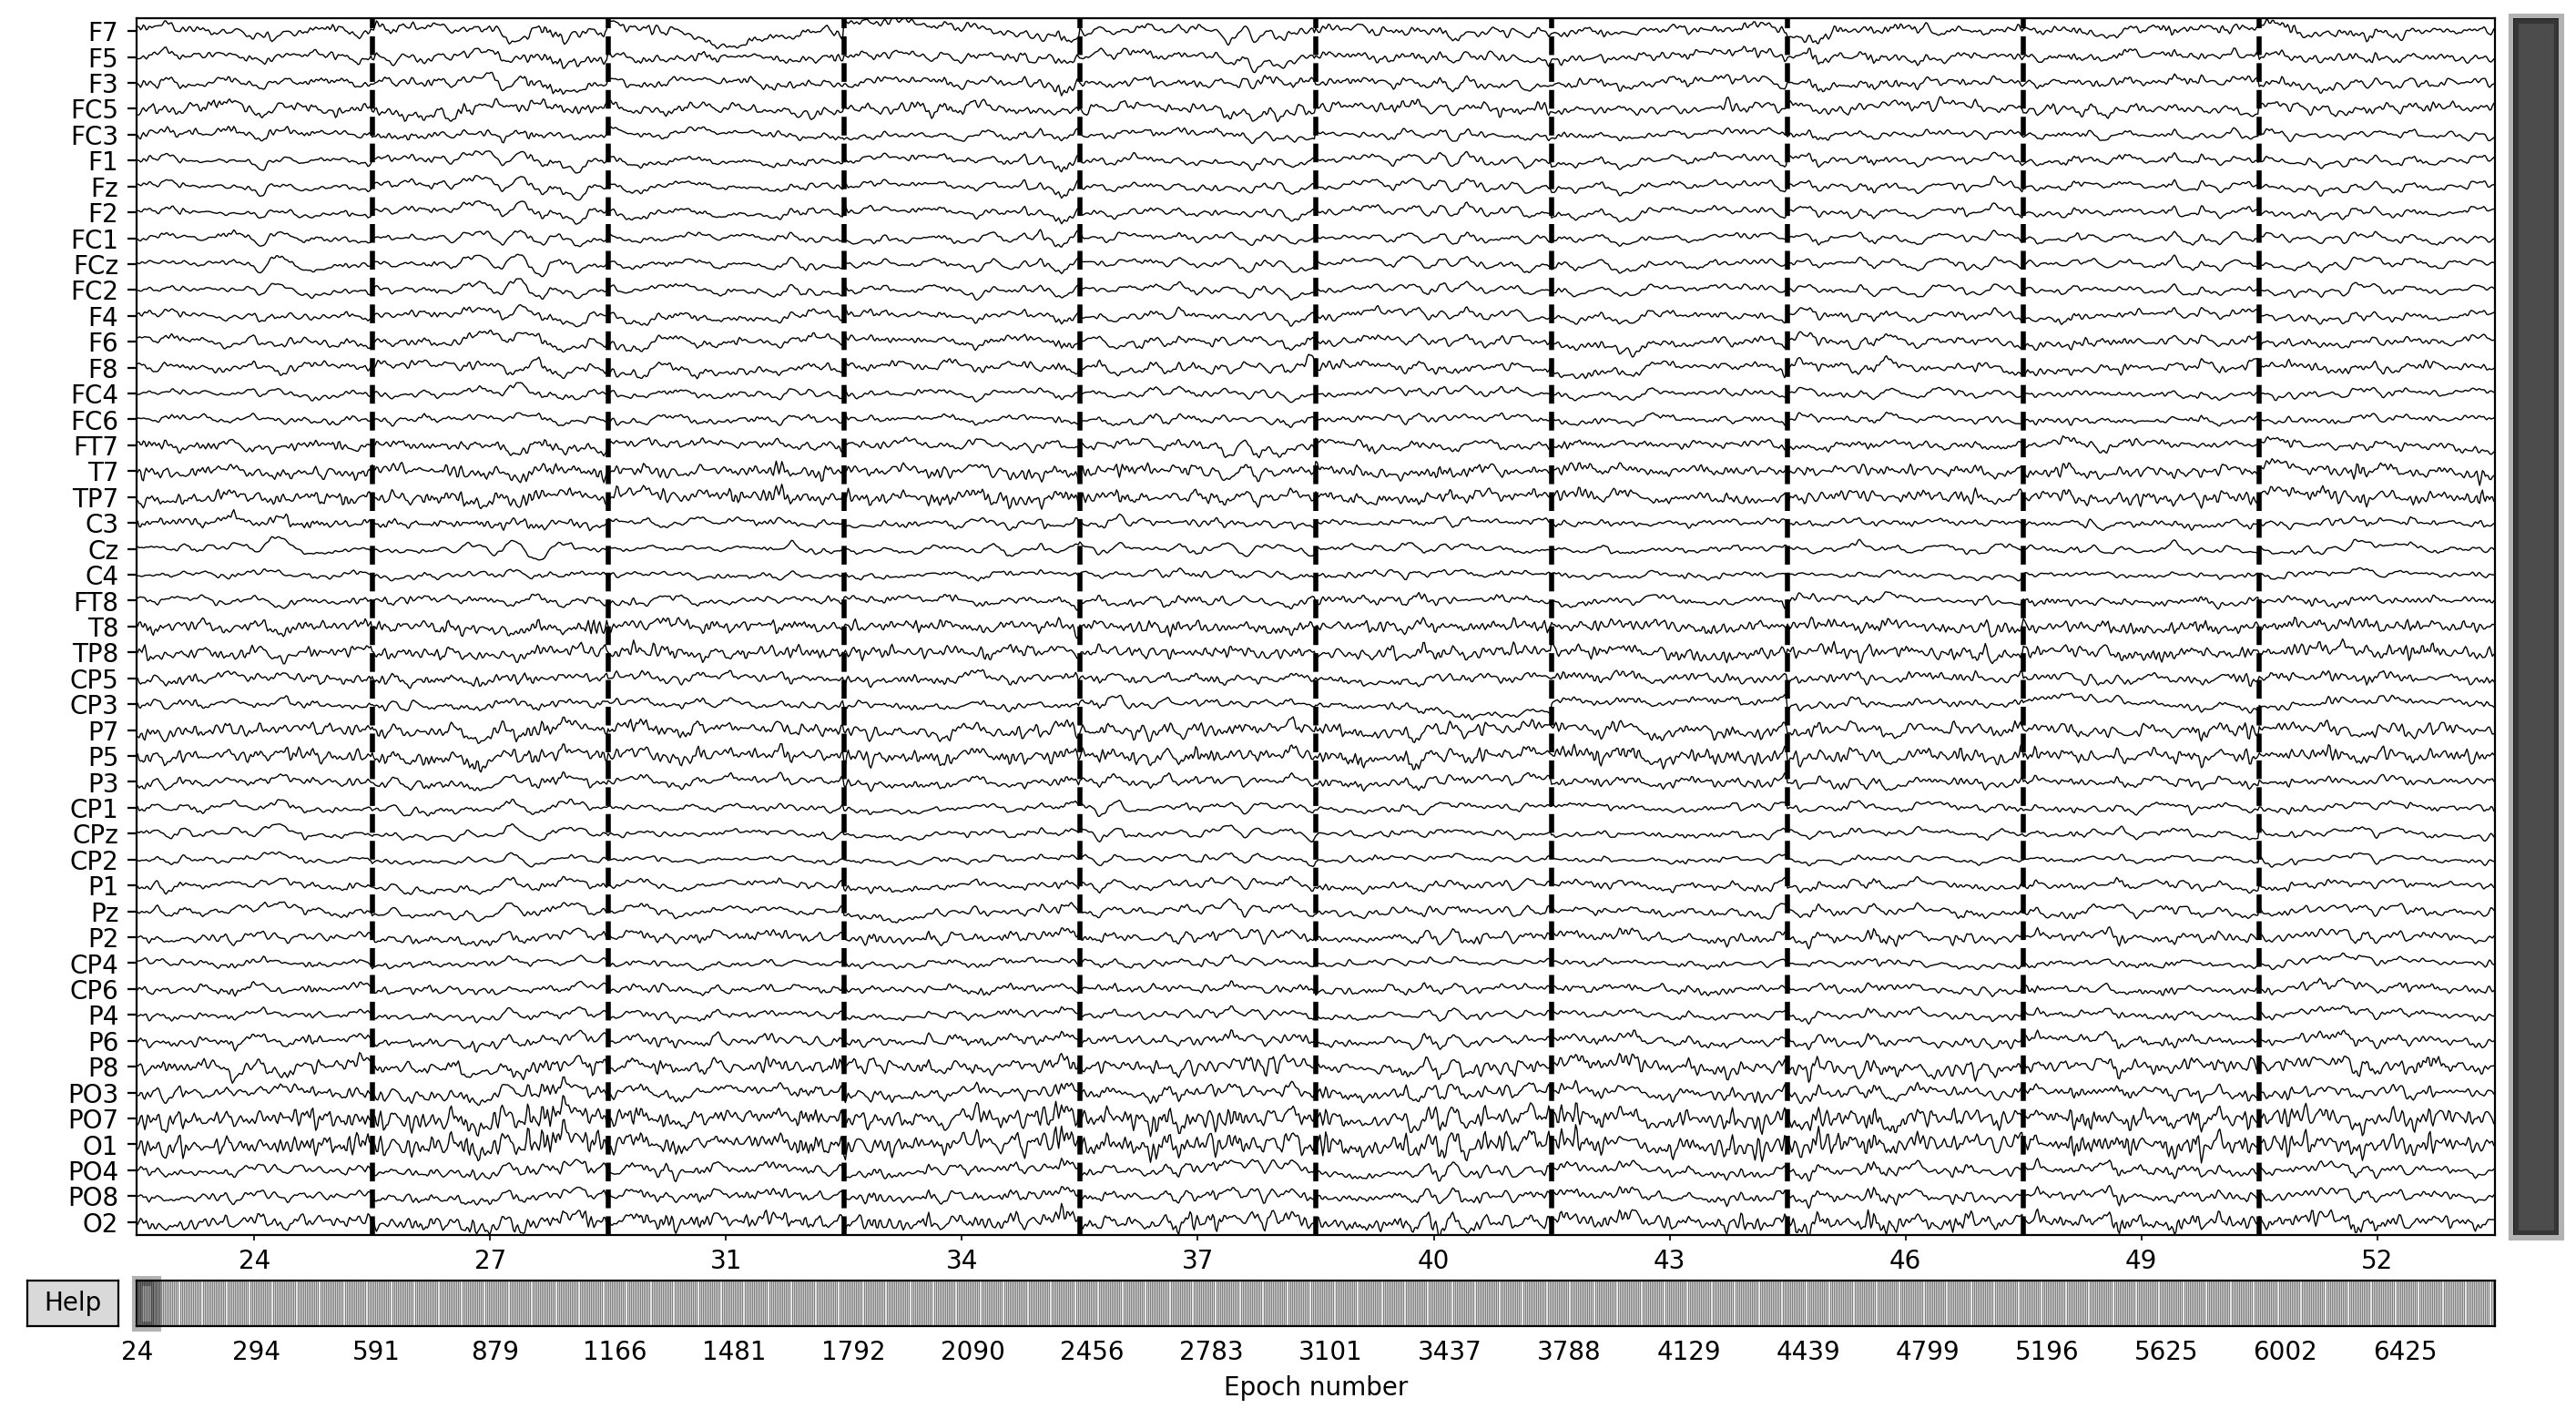

Dropped 0 epochs: 
Channels marked as bad: none


In [28]:
epochs_evoked.plot(n_epochs=10,
                       n_channels=47,
                       # group_by='position',
                       scalings={'eeg': 20e-6})

In [ ]:
#bands = [(4, 8, 'Theta (4 - 8 Hz)'), (8, 13, 'Alpha (8 - 13 Hz)'), (13, 30, 'Beta (13 - 30 Hz)'), (30, 45, 'Gamma (30 - 45 Hz)')]
#epochs_ransac_ordered.plot_psd_topomap(bands=bands, vlim='joint', ch_type='eeg')

In [ ]:
evoked_epoch_1_H = epochs_evoked["epoch == 1 & triplet == 'H'"].average()

In [ ]:
evoked_epoch_1_H.detrend().plot()

In [ ]:
evoked_epoch_1_H.detrend().plot_joint(times=[0.0, 0.11, 0.15, 0.3, 0.6, 0.7])

In [ ]:
epochs_evoked["epoch == 1 & triplet == 'H'"].plot_psd()